## Calculateクラス
### LoadData(): データを読みこむメソッド
- @param pop: 人口メッシュデータ（中心緯度経度、人口データを持つgeojson形式のデータ）
- @param com: 商業集積地区データ（中心緯度経度、売り場面積、売上高を持つgeojson形式のデータ）
            
### Dist(): ヒュべニの公式を用いた二点の距離を求めるメソッド
- @param p1: 緯度経度をリストで持つ地点
- @param p2: 緯度経度をリストで持つ地点

### oneAttract(): 顧客が店舗に行く確率を求めるメソッド
- @apram distList: すべての店舗までの距離のリスト
- @param areaList: すべての店舗の売場面積のリスト
- @param area: 面積補正係数
- @param dist: 距離補正係数
- @return 店舗の魅力度のリスト

### CleanList(): リストの-9999を0に変換するメソッド
- @param ln: 変換するリスト
- @return 変換後のリスト

### PredictSale(): 売上高を求めるメソッド
- @param pop_ptList 人口メッシュの緯度経度リスト
- @param pop_popList 人口メッシュの人口リスト
- @param com_ptList 商業施設の緯度経度リスト
- @param com_areaList 商業施設の売り場面積リスト
- @param area,dist 面積補正係数,距離補正係数
- @return predictSale 売上の予測値

## ライブラリ

In [2]:
import numpy as np
import json
import tqdm
from huffcalculate import Calculate
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Calculateクラスのコンストラクタ

In [3]:
calculate = Calculate('100_pop.geojson', 'B_com.geojson')
(pop, com) = calculate.LoadData()

## GeoJSON形式を読み込む

In [7]:
#100mメッシュの点を取得
pop_ptList = [i['geometry']['coordinates'] for i in pop['features']]

#A
#商業施設座標の取得
com_ptList = [i['geometry']['coordinates'] for i in com['features']]

#A
# 商業集積地区の名称を取得
com_name = [i['properties']['名称'] for i in com['features']]

#A
#売場面積の取得
com_areaList = [i['properties']['補正後売場面積'] for i in com['features']]

#100mメッシュの人口を取得, -9999を0に変換
pop_popList = [i['properties']['H27総人口'] for i in pop['features']]
pop_popList = calculate.CleanList(pop_popList)

#出力用に取得
#meshcodeの取得
pop_meshcodeList = [i['properties']['MESHCODE'] for i in pop['features']]
#keycodeの取得
pop_keycodeList = [i['properties']['KEYCODE'] for i in pop['features']]

#idを作成
id = [i['properties']['番号'] for i in com['features']]

# 基本プロット

(array([222.,  15.,   7.,   2.,   1.,   3.,   0.,   0.,   2.,   1.]),
 array([  623. ,  5919.9, 11216.8, 16513.7, 21810.6, 27107.5, 32404.4,
        37701.3, 42998.2, 48295.1, 53592. ]),
 <a list of 10 Patch objects>)

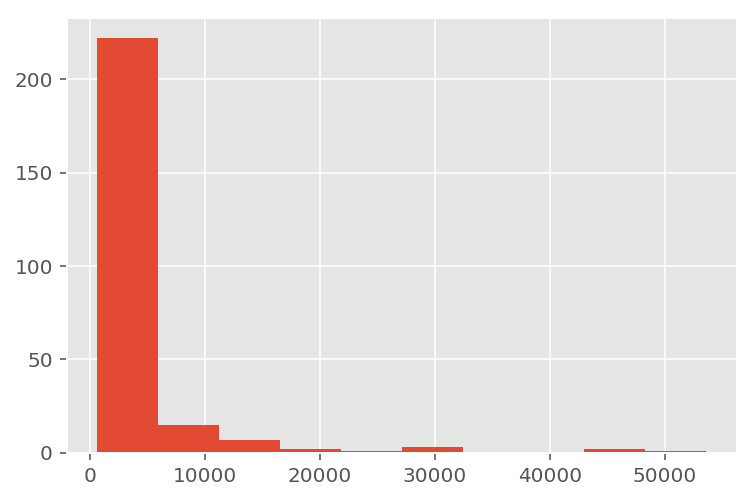

In [8]:
# 売場面積のプロット
plt.hist(com_areaList)

## 比例定数の設定
- 売上高/人口 = k(円/人)

In [10]:
k =0.5157552019268294

## 係数の定義
- @param area: 面積のべき数
- @param dist: 距離のべき数

In [11]:
area = 1.30
dist = 0.76

## 売上高の予測

In [12]:
predictList = calculate.PredictSale(pop_ptList, pop_popList, com_ptList, com_areaList, area, dist, 400)

100%|██████████| 32564/32564 [03:54<00:00, 138.59it/s]


# x = predictList*k

In [13]:
x = k*predictList

In [15]:
x

array([ 28255.50886459,   6531.28574951,   4484.9314862 ,   4738.28199059,
         2476.7092205 ,   2017.59554772,   2114.11122292,   1389.76712141,
         1159.9751573 ,    918.07108079,    820.74997265,    755.0927496 ,
          641.71832799,    508.61769445,    486.03781135,    488.38141409,
          474.39516529,    420.49604504,    408.85182395,  47533.71952968,
        14506.45403242,   8394.97022569,   7925.4557142 ,   3448.66441402,
         2058.88469628,   1903.08323826,   1264.54794572,   1273.67636323,
          629.48244125,    493.67202549,   3551.14865756,   2349.12031157,
         2189.67119073,   1410.97922935,   1335.99278204,   1063.41258607,
         1001.88743343,    652.0992605 ,    622.46839387,    393.03653519,
          405.93525725,  15277.0005523 ,   3549.99003489,   3224.06850185,
         3341.86532657,   1211.65165796,    913.97694062,    770.35859416,
          675.59651381,    647.94373019,    488.02319537,    413.98090497,
          415.41996622,  

(array([235.,  10.,   1.,   2.,   2.,   0.,   0.,   1.,   1.,   1.]),
 array([   285.83617014,  12078.31653356,  23870.79689698,  35663.27726041,
         47455.75762383,  59248.23798726,  71040.71835068,  82833.1987141 ,
         94625.67907753, 106418.15944095, 118210.63980438]),
 <a list of 10 Patch objects>)

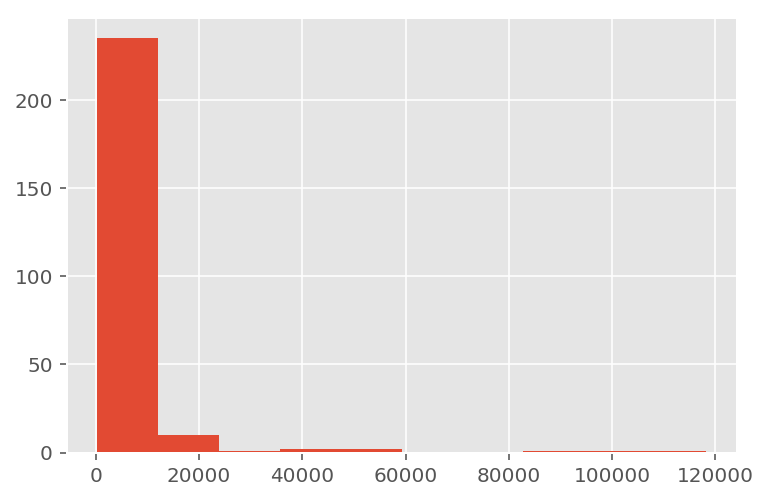

In [14]:
plt.hist(x)

## 誤差のcsv出力

In [16]:
data1 = pd.DataFrame(id)
data2 = pd.DataFrame(com_name)
data3 = pd.DataFrame(x)
data = pd.concat([data1, data2, data3], axis=1)
#utf-8 でダメなら　shift-jis で
data.to_csv("data.csv", encoding = "utf-8")